In [19]:
import numpy as np
import nibabel as nib
from nibabel import processing

import matplotlib.pyplot as plt
import albumentations as A

import os

import skimage.transform

In [23]:
model = os.path.abspath('./stroke_seg_b1000_final.keras')
dwi_path = '/hpf/projects/ndlamini/scratch/wgao/b1000_seg_data/test/43/43_B1000.nii.gz'
adc_path = '/hpf/projects/ndlamini/scratch/wgao/b1000_seg_data/test/43/43_ADC.nii.gz'

save_prediction_path = '/hpf/projects/ndlamini/scratch/wgao/b1000_seg_data/test/43/43_prediction.nii.gz'

In [14]:
%%bash -s {model} {dwi_path} {adc_path}
srun --mem=4G --gpus=1 python3 predict.py $1 $2 $3

2023-08-24 15:34:06.200536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 15:34:12.882691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-24 15:34:12.933505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-24 15:34:12.937413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

1/1 [==============================] - 6s 6s/step


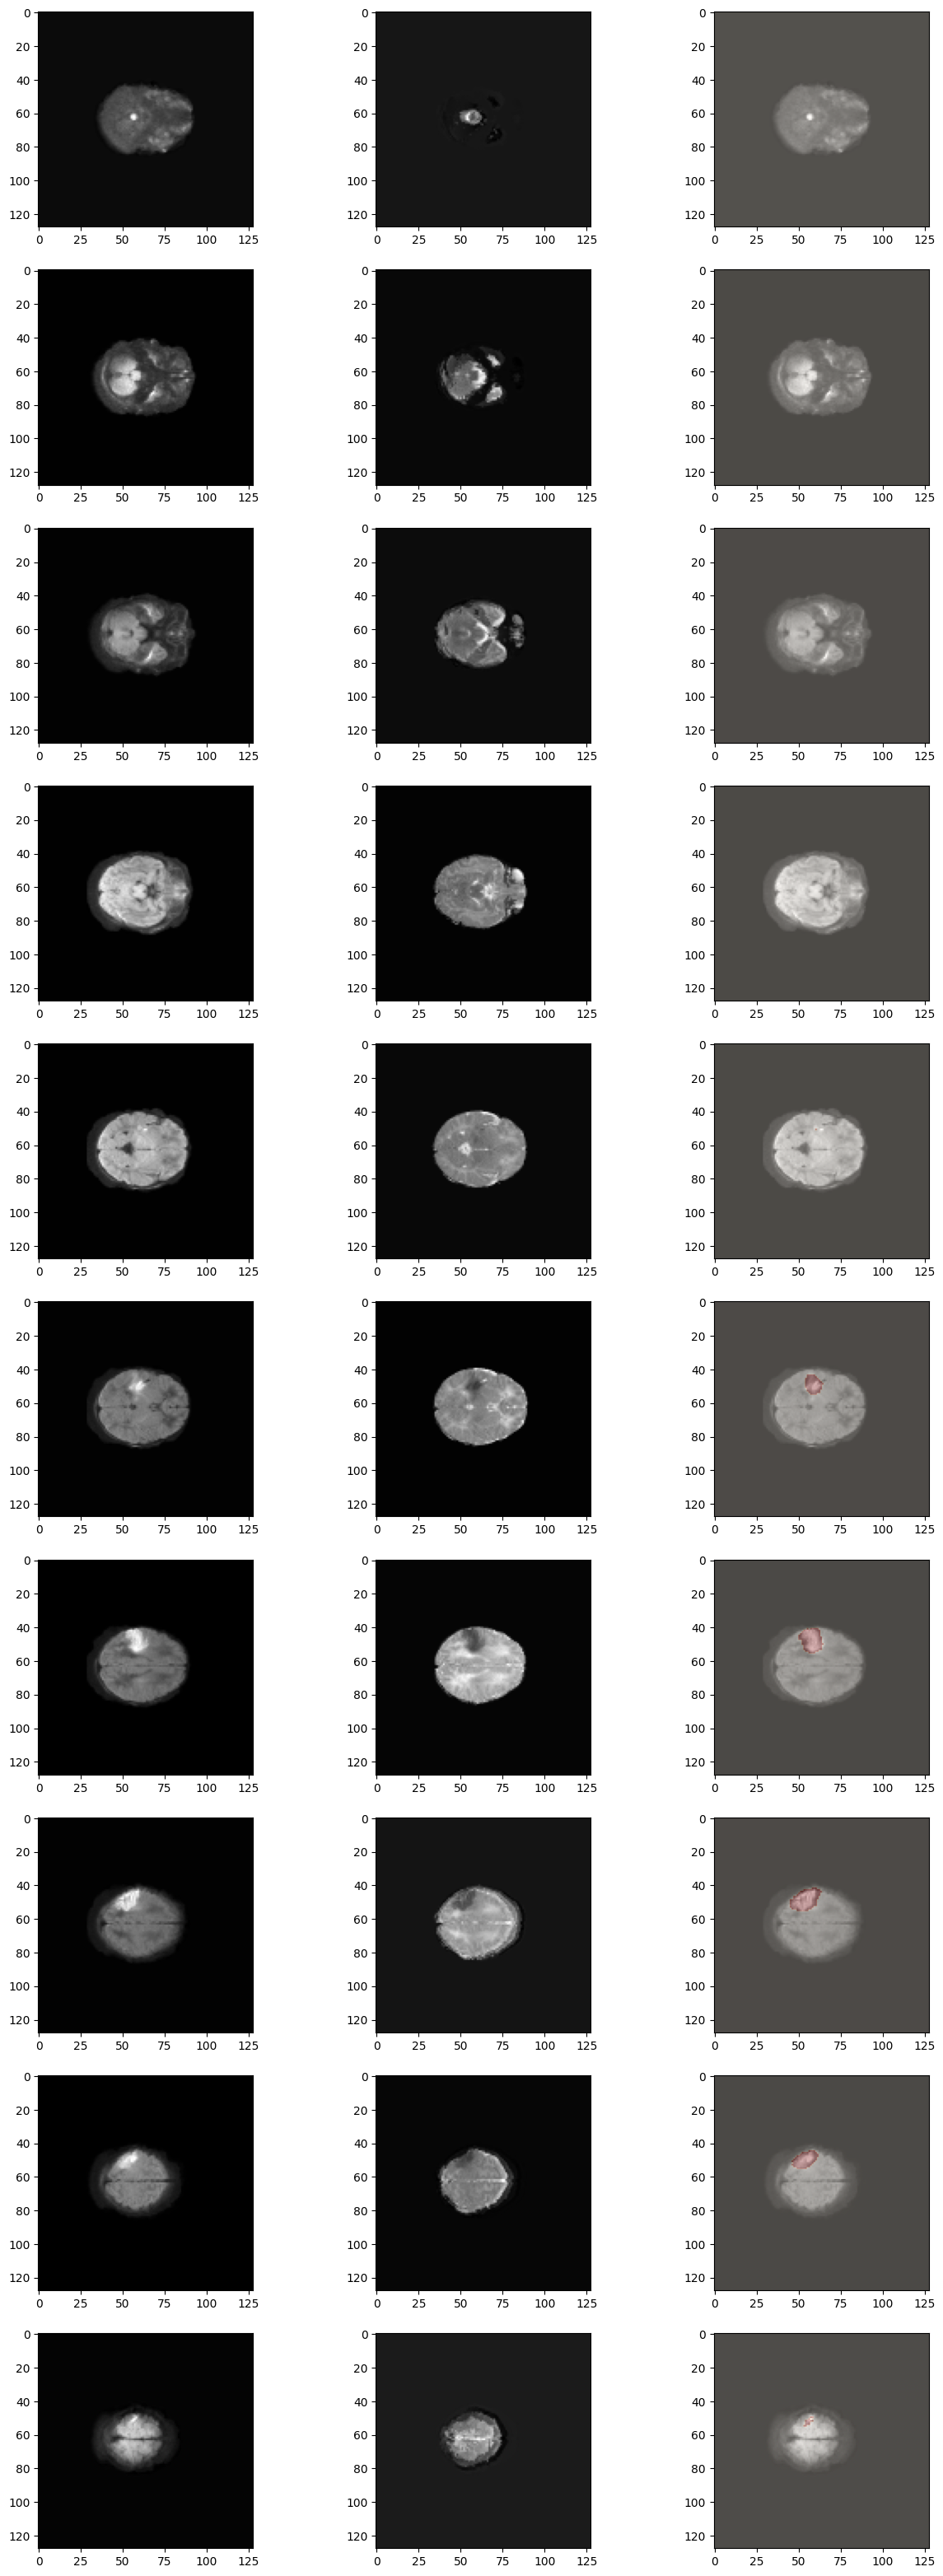

In [21]:
NUM_SLICES_TO_DISPLAY = 10

dwi = nib.load(dwi_path)
adc = nib.load(adc_path)

dwi_resampled = processing.conform(dwi)
adc_resampled = processing.conform(adc)

p = np.round(np.load('./pred.npy'))

# display the slices where the predicted mask is non-zero
non_zero_slices = np.sort(np.unique(np.nonzero(p[0 , :, :, :, 1])))
choices = np.round(np.linspace(non_zero_slices[0], non_zero_slices[-1], num=NUM_SLICES_TO_DISPLAY)).astype(int)

# init plots
f, ax = plt.subplots(len(choices), 3, figsize = (15, 4 * len(choices)))

for idx, slice in enumerate(choices):
    ax[idx][0].imshow(A.resize(dwi_resampled.get_fdata()[:, :, slice * 2], 128, 128), cmap='gray')
    ax[idx][1].imshow(A.resize(adc_resampled.get_fdata()[:, :, slice * 2], 128, 128), cmap='gray')
    ax[idx][2].imshow(A.resize(dwi_resampled.get_fdata()[:, :, slice * 2], 128, 128), cmap='gray')
    ax[idx][2].imshow(p[0 , :, :, slice, 1], cmap='OrRd', alpha=0.3)
plt.show()

In [19]:
# resize back up to 256 x 256 x256
result = skimage.transform.resize(p[0 , :, :, :, 1], (256, 256, 256), order=0)
result_img = nib.Nifti1Image(result, dwi_resampled.affine)

result_img = processing.conform(result_img, dwi.shape, dwi.header.get_zooms(), order=0)

nib.save(result_img, save_prediction_path)